In [46]:
import json
from PIL import Image
import csv
import glob
import os

In [47]:
# 저장할 디렉토리 설정
save_directory = './dataset/train'

# 저장 디렉토리가 없으면 생성
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [48]:
# 이미지 파일이 위치한 디렉토리
image_directory = './dataset/EMOIMG_Happy_TRAIN_01/'

In [49]:
# CSV 파일을 위한 헤더
csv_headers = ['filename', 'label']

# 저장된 이미지의 개수를 추적하는 변수
saved_images_count = 0

# CSV 파일 생성
with open('train_happy.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)
    
    # json_files 폴더 내의 모든 .json 파일에 대해 반복
    for json_file_path in glob.glob('./dataset/label/happy/*.json'):
        # JSON 파일을 읽고 Python dictionary로 변환
        with open(json_file_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
        
        for item in json_data:
            # 원본 이미지 파일 이름
            original_filename = item['filename']
            # '\\' 앞부분까지의 이름 추출
            base_pattern = original_filename.split('\\')[0]
            
            # 해당 패턴을 포함하는 모든 파일 찾기 (하위 디렉토리 포함)
            matching_files = glob.glob(f"{image_directory}**/{base_pattern}*", recursive=True)
            
            if matching_files:
                # 일치하는 파일이 있다면, 첫 번째 파일 사용
                image_path = matching_files[0]
            else:
                # 일치하는 파일이 없다면, 다음 항목으로 넘어감
                print(f"No matching file found for pattern {base_pattern}")
                continue
            
            # 얼굴 표정 라벨
            label = item['annot_A']['faceExp']
            
            # 이미지 불러오기
            try:
                with Image.open(image_path) as img:
                    # label과 annot_B의 표정, annot_C의 표정 일치할 때 이미지 crop 수행
                    if label == item['annot_B']['faceExp'] and item['annot_C']['faceExp']:
                        # Bounding box 좌표 추출
                        boxes = item['annot_A']['boxes']
                        minX, minY, maxX, maxY = boxes['minX'], boxes['minY'], boxes['maxX'], boxes['maxY']
                    
                        # 이미지 Crop
                        cropped_img = img.crop((minX-50, minY-50, maxX+50, maxY+50))
                    
                        # Crop된 이미지 저장 경로 설정
                        cropped_filepath = os.path.join(save_directory, os.path.basename(image_path))
                    
                        # Crop된 이미지 저장
                        cropped_img.save(cropped_filepath)
                    
                        # CSV 파일에 파일명과 라벨 쓰기
                        writer.writerow([cropped_filepath, label])
                    
                        # 이미지가 성공적으로 저장되면 카운터 증가
                        saved_images_count += 1
                    
            except IOError:
                print(f"Error opening or processing image {image_path}")

# 저장된 이미지의 총 개수 출력
print(f"Total saved images: {saved_images_count}")

Total saved images: 2290


In [50]:
import cv2
import tempfile
import shutil
import numpy as np

In [52]:
def clean_csv_file(original_csv_path):
    # 임시 파일 생성
    temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')
    with open(original_csv_path, 'r', encoding='utf-8', newline='') as csvfile, temp_file:
        reader = csv.reader(csvfile)
        writer = csv.writer(temp_file)

        # 첫 번째 행(헤더)을 읽고, 임시 파일에도 쓴다
        headers = next(reader)
        writer.writerow(headers)

        # 각 행에 대해 파일 경로를 확인하고, 파일이 존재하면 임시 파일에 쓴다
        for row in reader:
            file_path = row[0]
            # 윈도우 환경에서 경로 문제를 해결하기 위해 '\\'를 os.sep로 변경
            file_path = file_path.replace('\\', os.sep)
            if os.path.exists(file_path):
                writer.writerow(row)
    
    # 원본 파일을 새로운 내용으로 교체
    shutil.move(temp_file.name, original_csv_path)

# 원본 CSV 파일 경로
original_csv_path = './dataset/label/.csv'

# 함수 실행
clean_csv_file(original_csv_path)

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# CSV 파일 읽기
df = pd.read_csv('labels_updated.csv')

# 라벨 재정의 함수
def redefine_label(label):
    if label == '기쁨':
        return 'positive'
    elif label in ['당황', '분노', '불안', '상처', '슬픔']:
        return 'negative'
    elif label == '중립':
        return 'neutral'
    else:
        return label

# 라벨 재정의 적용
df['label'] = df['label'].apply(redefine_label)

# 재정의된 라벨로 업데이트된 데이터를 새로운 CSV 파일에 저장
df.to_csv('labels_updated.csv', index=False)

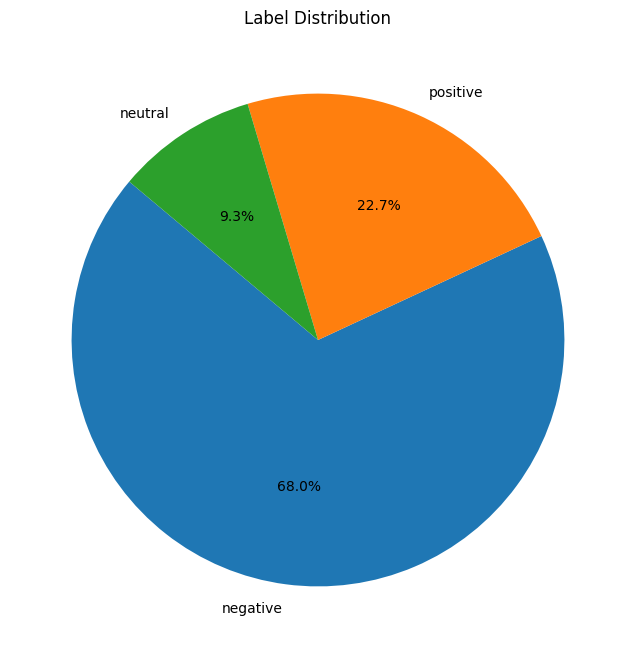

In [57]:
# 각 라벨별 비율 계산
label_counts = df['label'].value_counts()
label_ratios = label_counts / label_counts.sum()

# 원형 그래프 시각화
plt.figure(figsize=(8, 8))
plt.pie(label_ratios, labels=label_ratios.index, autopct='%1.1f%%', startangle=140)
plt.title('Label Distribution')
plt.show()